In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
pred_data_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'


## Hyperparameters

In [3]:
kernel_size_cnn = 3
kernel_size_pool = 2
stride1 = 1
stride2 = 2
padding = 1
batch_size = 128
epochs = 50
ratio = 64
in_channels = 3
hidden_channels1 = 64
hidden_channels2 = 128

## Data Viz

In [4]:
from PIL import Image
img = Image.open('/kaggle/input/intel-image-classification/seg_train/seg_train/forest/10007.jpg')
img.size

(150, 150)

In [5]:
train_df = pd.DataFrame()
name = []
counts = []
for i in os.listdir(train_data_dir):
    name.append(i)
    counts.append(len(os.listdir(train_data_dir+'/'+i)))
train_df['Name'] = name
train_df['Counts'] = counts
train_df.head()

,Name,Counts
0,mountain,2512
1,street,2382
2,buildings,2191
3,sea,2274
4,forest,2271


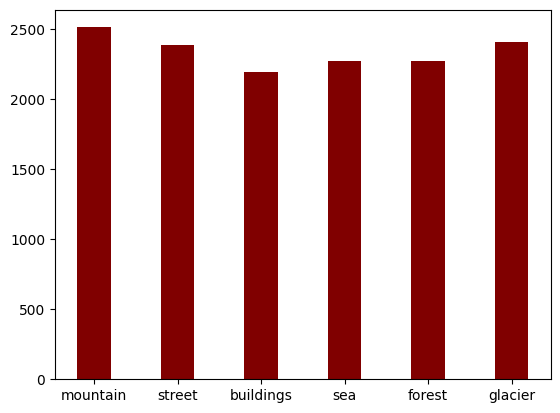

In [6]:
plt.bar(train_df['Name'], train_df['Counts'], color ='maroon',width = 0.4);

In [7]:
test_df = pd.DataFrame()
name = []
counts = []
for i in os.listdir(test_data_dir):
    
    name.append(i)
    counts.append(len(os.listdir(test_data_dir+'/'+i)))
test_df['Name'] = name
test_df['Counts'] = counts
test_df.head()

,Name,Counts
0,mountain,525
1,street,501
2,buildings,437
3,sea,510
4,forest,474


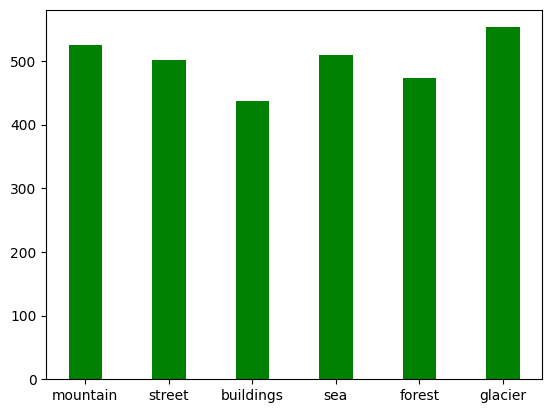

In [8]:
plt.bar(test_df['Name'], test_df['Counts'], color ='green',width = 0.4);

In [9]:
train_df['Counts'].sum(), test_df['Counts'].sum()

(14034, 3000)

## Finding Mean and Standard deviation to normalize images

In [10]:
train = datasets.ImageFolder(train_data_dir,
                   transform = transforms.Compose([
                       transforms.Resize(ratio),
                       transforms.RandomCrop(ratio),
                       transforms.ToTensor()
                   ]))
train_data_loader = torch.utils.data.DataLoader(train, 64, shuffle=True, num_workers=3, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
len(train_data_loader) * 64

14080

In [12]:
def get_mean_std(data_loader):
    sum_, squared_sum, batches = 0, 0, 0
    for data, _ in data_loader:
        sum_ += torch.mean(data, dim=([0, 2, 3]))
        squared_sum += torch.mean(data ** 2, dim=([0, 2, 3]))
        batches += 1
    
    mean = sum_ / batches
    std = (squared_sum / batches - mean ** 2) ** 0.5
    return mean, std

In [13]:
mean, std = get_mean_std(train_data_loader)
mean, std

(tensor([0.4302, 0.4576, 0.4539]), tensor([0.2481, 0.2468, 0.2807]))

## Seeding

In [14]:
random_seed = 42
torch.manual_seed(random_seed)

## Transforms

In [15]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(ratio),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
    transforms.Resize(ratio),
    transforms.CenterCrop(ratio),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

            

In [16]:
train_transform

Compose(
    RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.4302, 0.4576, 0.4539]), std=tensor([0.2481, 0.2468, 0.2807]))
)

In [17]:
test_transform

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=tensor([0.4302, 0.4576, 0.4539]), std=tensor([0.2481, 0.2468, 0.2807]))
)

## Converting into datasets

In [18]:
train_datasets = datasets.ImageFolder(os.path.join(train_data_dir),
                                      transform=train_transform)
test_datasets = datasets.ImageFolder(os.path.join(test_data_dir),
                                    transform=test_transform)

In [19]:
len(train_datasets), len(test_datasets)

(14034, 3000)

In [20]:
train_datasets.classes, test_datasets.classes

(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

In [21]:
classes = len(train_datasets.classes)
classes

6

In [22]:
val_size = int(len(train_datasets) * 0.2)
train_size = len(train_datasets) - val_size
train_datasets, val_datasets = torch.utils.data.random_split(train_datasets,
                                                             [train_size, val_size])
len(train_datasets), len(val_datasets), len(test_datasets)

(11228, 2806, 3000)

In [23]:
train_dataloaders = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size * 2, shuffle=True,
                                                num_workers=2, pin_memory=True)
val_dataloaders = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size * 2,
                                              num_workers=2, pin_memory=True)
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size * 2,
                                               num_workers=2, pin_memory=True)

In [24]:
len(train_dataloaders), len(val_dataloaders), len(test_dataloaders)

(44, 11, 12)

In [25]:
len(train_dataloaders) * batch_size * 2, len(val_dataloaders) * batch_size * 2, len(test_dataloaders) * batch_size * 2

(11264, 2816, 3072)

## Data Viz

In [26]:
def denormalize(images, mean, std):
    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    return images * std + mean

def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, mean, std)
        ax.imshow(torchvision.utils.make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
        break

/tmp/ipykernel_28/3427750598.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).reshape(1, 3, 1, 1)
/tmp/ipykernel_28/3427750598.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).reshape(1, 3, 1, 1)


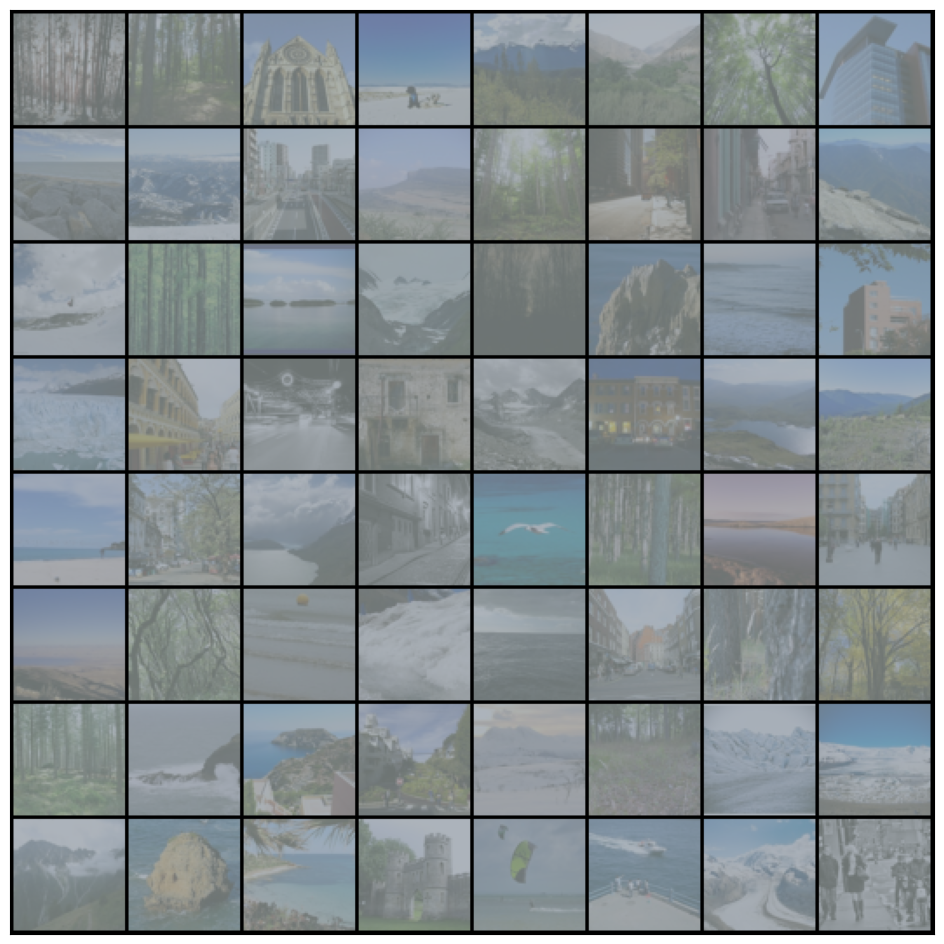

In [27]:
show_batch(train_data_loader)

## Changing from CPU to GPU if available

In [28]:
CUDA = torch.cuda.is_available()
CUDA

True

# CNN

In [38]:
class CNN22(nn.Module):
    # in_channels is the color channels in our case it is 3
    
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels,
                 kernel_size_cnn=3, kernel_size_pool=2,
                 stride1=1, stride2=2, padding=1):
        
        super().__init__()
        # padding_value = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        
        self.cnn1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels1,
                               kernel_size=kernel_size_cnn,
                               stride=stride1,
                               padding=padding)
        
        self.batchnorm1 = nn.BatchNorm2d(hidden_channels1)
        
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size_pool)
        
        
        
        # padding = (kernel_size - 1) / 2 => (3 - 1)/ 2 => 1
        self.cnn2 = nn.Conv2d(in_channels=hidden_channels1,
                             out_channels=hidden_channels1,
                             kernel_size=kernel_size_cnn,
                             stride=stride1,
                             padding=padding)
        
        
        self.batchnorm2 = nn.BatchNorm2d(hidden_channels2)
        
        self.fc1 = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.linear_layer = 1024
        
        self.fc2 = nn.Linear(self.linear_layer, out_channels)
        
    def forward(self, x):
        
        outputs = []
        labels = []
        
        out = self.cnn1(x)
        outputs.append(out)
        labels.append('conv2d')
        
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
                
        out = self.relu(out)
        outputs.append(out)
        labels.append('ReLU')
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('MaxPool')
        # [256, 32, 32, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
    
        
#         out = self.relu(out)
        out = F.softmax(out, dim=2)
        out = F.softmax(out, dim=3)
        labels.append('ReLU')
        outputs.append(out)
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        # [256, 16, 16, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
#         out = self.relu(out)
        out = F.softmax(out, dim=2)
        out = F.softmax(out, dim=3)
        labels.append('ReLU')
        outputs.append(out)
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        # [256, 8, 8, 64]
        
        
        out = self.cnn2(out)        
        labels.append('conv2d')
        outputs.append(out)
    
        out = self.batchnorm1(out)
        outputs.append(out)
        labels.append('BatchNorm')
        
#         out = self.relu(out)
        out = F.softmax(out, dim=2)
        out = F.softmax(out, dim=3)
        labels.append('ReLU')
        outputs.append(out)
        
        out = self.maxpool(out)
        outputs.append(out)
        labels.append('Maxpool')
        
        # [256, 4, 4, 64]
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        
        
        return out
        

In [39]:
model = CNN22(in_channels=in_channels,
            hidden_channels1=hidden_channels1,
            hidden_channels2=hidden_channels2,
            out_channels=classes)
if CUDA:
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [40]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    correct = 0
    iterations = 0
    iter_loss = 0
    model.train()
    
    for i, (inputs, labels) in enumerate(train_dataloaders):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        
        iterations += 1
        
    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct / len(train_datasets)))
    print(f"Epoch [{epoch + 1} / {epochs}], Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_accuracy[-1]:.3f}")
    

Epoch [1 / 50], Training Loss: 1.884, Training Accuracy: 16.895
Epoch [2 / 50], Training Loss: 1.801, Training Accuracy: 17.510
Epoch [3 / 50], Training Loss: 1.815, Training Accuracy: 16.815
Epoch [4 / 50], Training Loss: 1.819, Training Accuracy: 16.441
Epoch [5 / 50], Training Loss: 1.820, Training Accuracy: 16.984
Epoch [6 / 50], Training Loss: 1.823, Training Accuracy: 16.762
Epoch [7 / 50], Training Loss: 1.812, Training Accuracy: 17.082
Epoch [8 / 50], Training Loss: 1.826, Training Accuracy: 16.708
Epoch [9 / 50], Training Loss: 1.821, Training Accuracy: 17.091
Epoch [10 / 50], Training Loss: 1.800, Training Accuracy: 16.842
Epoch [11 / 50], Training Loss: 1.814, Training Accuracy: 16.842
Epoch [12 / 50], Training Loss: 1.811, Training Accuracy: 17.127
Epoch [13 / 50], Training Loss: 1.826, Training Accuracy: 16.388
Epoch [14 / 50], Training Loss: 1.845, Training Accuracy: 16.637
Epoch [15 / 50], Training Loss: 1.814, Training Accuracy: 16.227
Epoch [16 / 50], Training Loss: 1.

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map, 0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())